# A number of Life-Cycle Examples in HARK

This notebook will offer a number of examples of solving and simulating life-cycle models using the HARK toolkit. Although it is named as a tutorial, this note should be used more as a reference for the original models that the user would like to build using the toolkit (for example, if you are interested in modeling agents who experience seasonal shocks over an infinite horizon, you should adapt the final exercise to your own setting).

In [1]:
# Attempt at combining the imports from both notebooks -- it works!
import numpy as np

from HARK.ConsumptionSaving.ConsIndShockModel import *
from HARK.utilities import plot_funcs

mystr = lambda number: f"{number:.4f}"

## 1. The model with age-dependent parameters

Recall the deterministic, life-cycle version of the perfect foresight model such that it accomodates age-dependent survival probability and/or income growth.

\begin{align}
V_t(M_t,Y_t) &= \max_{C_t}~U(C_t) + \beta \pi_t V_{t+1}(M_{t+1},Y_{t+1}), \\
& s.t.  \\
%A_t &= M_t - C_t, \\
M_{t+1} &= R (M_{t}-C_{t}) + Y_{t+1}, \\
Y_{t+1} &= \Gamma_{t+1} Y_t, \\
\end{align}

Where $Y_t$ is an age-dependent income, $\pi_t$ is a survival  probability and $\Gamma_{t+1}$ is an income growth rate. Also $\pi_{T+1} =0$.

## 2. Introducing the `cycles` attribute

The `cycles` parameter has a more general use than was presented in the [Gentle Introduction to HARK](https://docs.econ-ark.org/examples/Gentle-Intro/Gentle-Intro-To-HARK.html) notebook. In general, it tells HARK **how many times the one period consumer's problem needs to be solved with the given set of time-changing parameters.** In our microeconomic case, these parameters are LivPrb and PermGroFac (as the discount factor,  the CRRA parameter and risk free interest rate are assumed to be stable).

For both the finite and infinite-horizon settings, **the survival probabilities and income growth rates are different in each period** and consumer **never faces the same parameter's combination.**

So, after specifying the lists of survival probabilities and income growth vectors with T+1 non-zero values, one needs only to set the cycles attribute to match the time horizon of interest (finite or infinite).

The cycles parameter can be used  by itself in the solution of the one period consumer's problem with time-changing parameters, or it can be used in conjuction with the `T_cycle` attribute, given an interest in simulating the model. As you will see in the examples towards the end of this notebook, the use of the T_cycle parameter is more straightforward.

## 3. Examples (solution only)

### 3.1 Finite horizon, life-cycle problem

First, consider a finite-horizon life cycle example. We create an agent-type object with maximal lifespan set to 11, and decreasing survival probability and inverse u-shape income dynamics up to period 6 (the consumer retired). Notice that this is acheived by the list of parameters in the code block below.

In [2]:
LifeCycle_dictionary = {
    "CRRA": 2.0,
    "Rfree": 10 * [1.04],
    "DiscFac": 0.98,
    "LivPrb": [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.90],
    "PermGroFac": [1.01, 1.01, 1.01, 1.02, 1.00, 0.99, 0.5, 1.0, 1.0, 1.0],
    "T_cycle": 10,  # Our time varying parameters are a list with 10 elements
    "cycles": 1,  # Repeats once
}

LC_agent = PerfForesightConsumerType(**LifeCycle_dictionary)

To solve the model, we use the $\texttt{solve}$ method method finds value and consumption function. In case of $\Gamma_t \neq 1.0$, these functions are defined on the **normalized by $Y_t$** space of  the cash-in hands arguments. It is important to remember that, when you will plot them.

In [3]:
LC_agent.solve()

Consumption functions


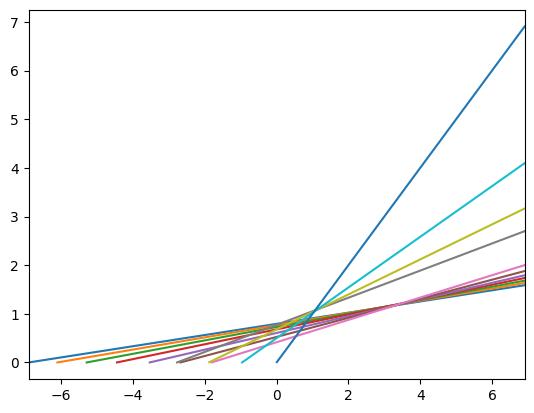

In [4]:
LC_agent.unpack("cFunc")

min_v = min(LC_agent.solution[t].mNrmMin for t in range(11))
max_v = -min_v
print("Consumption functions")
plot_funcs(LC_agent.cFunc[:], min_v, max_v)

### 3.2 Infinite horizon, cyclical problem

Next, consider an infinite horizon, life-cycle problem in the following setting: the consumer lives with certainty but, her income perform cycles. During each cycles she experience two periods of the income increase and two of the decrease.

We assume that for each cycle the income growth factors are: [1.05,1.1, 0.95, 0.92].  In each of the periods, we also assume that survival probability is 1. The rest of the parameters is the same as in the previous example.

Below, we create a HARK agent-type object with the described above income cycles and solve the model. Notice that the cycles parameter is set to $0$ in this case.

In [6]:
Cyc_dictionary = {
    "CRRA": 2.0,
    "Rfree": 4 * [1.03],
    "DiscFac": 0.96,
    "LivPrb": [1.05, 1.1, 0.95, 0.92],
    "PermGroFac": 4 * [1.0],
    "cycles": 0,  # 0 for infinite horizon
    "T_cycle": 4,
}

Cyc_agent = PerfForesightConsumerType(**Cyc_dictionary)
Cyc_agent.solve()

## 4. Examples (simulation and solution)

### 4. 1 An aside on the `T_cycles` attribute

When moving on to the simulation step in the model, the `T_cycles` parameter will need to be defined appropraitely. The best way to understand and implement this, again, is through adapting the following examples to your own liking.

However, as a general rule of thumb: *the value of the `T_cycles` parameter should match the number of periods to be solved in the agent's life-cycle problem.*

### 4.2 Finite horizon, life-cycle problem

Here, we consider a more advanced example using the ConsIndConsumerType class of the toolkit. Suppose again that we want to represent consumers of this class with a *lifecycle*-- parameter values that differ by age, with a finite end point beyond which the individual cannot surive.  This can be done very easily by simply specifying the time-varying attributes $\texttt{PermGroFac}$, $\texttt{LivPrb}$, $\texttt{PermShkStd}$, and $\texttt{TranShkStd}$ as Python *lists* specifying the sequence of periods these agents will experience, from beginning to end.

In the cell below, we define a parameter dictionary for a rather short ten period lifecycle, with arbitrarily chosen parameters.  For a more realistically calibrated (and much longer) lifecycle model, see the [SolvingMicroDSOPs REMARK](https://github.com/econ-ark/REMARK/blob/master/REMARKs/SolvingMicroDSOPs.md).

In [8]:
LifecycleDict = {  # Click arrow to expand this fairly large parameter dictionary
    # Parameters shared with the perfect foresight model
    "CRRA": 2.0,  # Coefficient of relative risk aversion
    "Rfree": 10 * [1.03],  # Interest factor on assets
    "DiscFac": 0.96,  # Intertemporal discount factor
    "LivPrb": [0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 1.0],
    "PermGroFac": [1.01, 1.01, 1.01, 1.02, 1.02, 1.02, 0.7, 1.0, 1.0, 1.0],
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd": [0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0, 0, 0],
    "PermShkCount": 7,  # Number of points in discrete approximation to permanent income shocks
    "TranShkStd": [0.3, 0.2, 0.1, 0.3, 0.2, 0.1, 0.3, 0, 0, 0],
    "TranShkCount": 7,  # Number of points in discrete approximation to transitory income shocks
    "UnempPrb": 0.05,  # Probability of unemployment while working
    "IncUnemp": 0.3,  # Unemployment benefits replacement rate
    "UnempPrbRet": 0.0005,  # Probability of "unemployment" while retired
    "IncUnempRet": 0.0,  # "Unemployment" benefits when retired
    "T_retire": 7,  # Period of retirement (0 --> no retirement)
    "tax_rate": 0.0,  # Flat income tax rate (legacy parameter, will be removed in future)
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin": 0.001,  # Minimum end-of-period "assets above minimum" value
    "aXtraMax": 20,  # Maximum end-of-period "assets above minimum" value
    "aXtraCount": 48,  # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac": 3,  # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra": None,  # Additional values to add to aXtraGrid
    # A few other parameters
    "BoroCnstArt": -1.0,  # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool": True,  # Whether to calculate the value function during solution
    "CubicBool": False,  # Preference shocks currently only compatible with linear cFunc
    "T_cycle": 10,  # Number of periods in the cycle for this agent type
    # Parameters only used in simulation
    "AgentCount": 100,  # Number of agents of this type
    "T_sim": 11,  # Number of periods to simulate
    "aNrmInitMean": -6.0,  # Mean of log initial assets
    "aNrmInitStd": 0.0,  # Standard deviation of log initial assets
    "pLvlInitMean": 0.0,  # Mean of log initial permanent income
    "pLvlInitStd": 0.0,  # Standard deviation of log initial permanent income
    "PermGroFacAgg": 1.0,  # Aggregate permanent income growth factor
    "T_age": 11,  # Age after which simulated agents are automatically killed
}

In this case, we have specified a ten period model in which retirement happens in period $t=7$.  Agents in this model are more likely to die as they age, and their permanent income drops by 30\% at retirement.  Let's make and solve this lifecycle example, then look at the $\texttt{solution}$ attribute.

In [9]:
LifecycleExample = IndShockConsumerType(**LifecycleDict)
LifecycleExample.cycles = (
    0  # Make this consumer live a sequence of periods -- a lifetime -- exactly once
)
LifecycleExample.solve()
print("First element of solution is", LifecycleExample.solution[0])
print("Solution has", len(LifecycleExample.solution), "elements.")

First element of solution is <HARK.ConsumptionSaving.ConsIndShockModel.ConsumerSolution object at 0x00000185BB00A170>
Solution has 10 elements.


This was supposed to be a *ten* period lifecycle model-- why does our consumer type have *eleven* elements in its $\texttt{solution}$?  It would be more precise to say that this specification has ten *non-terminal* periods. The solution to the 11th and final period in the model would be the same for every set of parameters: consume $c_t = m_t$, because there is no future.  In a lifecycle model, the terminal period is assumed to exist; the $\texttt{LivPrb}$ parameter does not need to end with a $0.0$ in order to guarantee that survivors die.

We can quickly plot the consumption functions in each period of the model:

Consumption functions across the lifecycle:


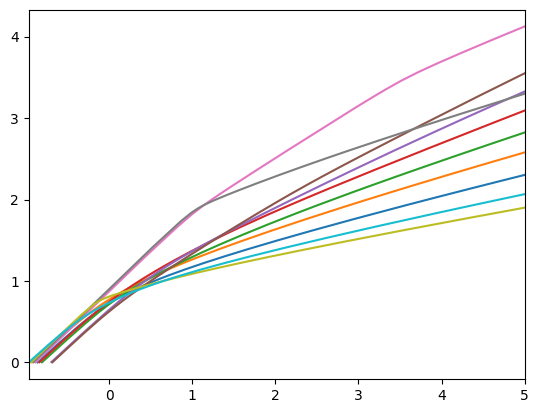

In [10]:
print("Consumption functions across the lifecycle:")
mMin = np.min(
    [LifecycleExample.solution[t].mNrmMin for t in range(LifecycleExample.T_cycle)],
)
LifecycleExample.unpack(
    "cFunc",
)  # This makes all of the cFuncs accessible in the attribute cFunc
plot_funcs(LifecycleExample.cFunc, mMin, 5)

### 4.3 Infinite horizon, cyclical problem

As a final example, we model consumers who face an infinite horizon, but who do *not* face the same problem in every period.  Consider someone who works as a ski instructor: they make most of their income for the year in the winter, and make very little money in the other three seasons.

We can represent this type of individual as a four period, infinite horizon model in which expected "permanent" income growth varies greatly across seasons.

In [12]:
CyclicalDict = {  # Click the arrow to expand this parameter dictionary
    # Parameters shared with the perfect foresight model
    "CRRA": 2.0,  # Coefficient of relative risk aversion
    "Rfree": 4 * [1.03],  # Interest factor on assets
    "DiscFac": 0.96,  # Intertemporal discount factor
    "LivPrb": 4 * [0.98],  # Survival probability
    "PermGroFac": [1.082251, 2.8, 0.3, 1.1],
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd": [0.1, 0.1, 0.1, 0.1],
    "PermShkCount": 7,  # Number of points in discrete approximation to permanent income shocks
    "TranShkStd": [0.2, 0.2, 0.2, 0.2],
    "TranShkCount": 7,  # Number of points in discrete approximation to transitory income shocks
    "UnempPrb": 0.05,  # Probability of unemployment while working
    "IncUnemp": 0.3,  # Unemployment benefits replacement rate
    "UnempPrbRet": 0.0005,  # Probability of "unemployment" while retired
    "IncUnempRet": 0.0,  # "Unemployment" benefits when retired
    "T_retire": 0,  # Period of retirement (0 --> no retirement)
    "tax_rate": 0.0,  # Flat income tax rate (legacy parameter, will be removed in future)
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin": 0.001,  # Minimum end-of-period "assets above minimum" value
    "aXtraMax": 20,  # Maximum end-of-period "assets above minimum" value
    "aXtraCount": 48,  # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac": 3,  # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra": None,  # Additional values to add to aXtraGrid
    # A few other parameters
    "BoroCnstArt": 0.0,  # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool": True,  # Whether to calculate the value function during solution
    "CubicBool": False,  # Preference shocks currently only compatible with linear cFunc
    "T_cycle": 4,  # Number of periods in the cycle for this agent type
    # Parameters only used in simulation
    "AgentCount": 10000,  # Number of agents of this type
    "T_sim": 120,  # Number of periods to simulate
    "aNrmInitMean": -6.0,  # Mean of log initial assets
    "aNrmInitStd": 1.0,  # Standard deviation of log initial assets
    "pLvlInitMean": 0.0,  # Mean of log initial permanent income
    "pLvlInitStd": 0.0,  # Standard deviation of log initial permanent income
    "PermGroFacAgg": 1.0,  # Aggregate permanent income growth factor
    "T_age": None,  # Age after which simulated agents are automatically killed
}

This consumer type's parameter dictionary is nearly identical to the original infinite horizon type we made, except that each of the time-varying parameters now have *four* values, rather than just one.  Most of these have the same value in each period *except* for $\texttt{PermGroFac}$, which varies greatly over the four seasons.  Note that the product of the four "permanent" income growth factors is almost exactly 1.0-- this type's income does not grow on average in the long run!

Let's make and solve this consumer type, then plot his quarterly consumption functions:

Quarterly consumption functions:


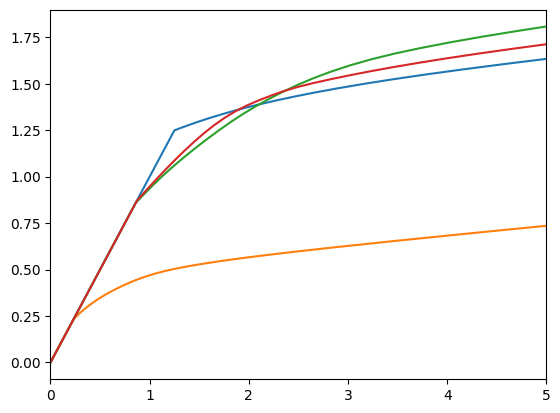

In [13]:
CyclicalExample = IndShockConsumerType(**CyclicalDict)
CyclicalExample.cycles = 0  # Make this consumer type have an infinite horizon
CyclicalExample.solve()

CyclicalExample.unpack("cFunc")
print("Quarterly consumption functions:")
mMin = min([X.mNrmMin for X in CyclicalExample.solution])
plot_funcs(CyclicalExample.cFunc, mMin, 5)

The very low orange consumption function corresponds to the quarter in which the ski instructors make most of their income.  They know that they are about to experience a 70% drop in "permanent" income, so they do not consume much *relative to their income this quarter*.  In the other three quarters, *normalized* consumption is much higher, as current "permanent" income is low relative to future expectations.  In *level*, the consumption chosen in each quarter is much more similar.